<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-09-01 10:18:23--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.1s    

2019-09-01 10:18:23 (184 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



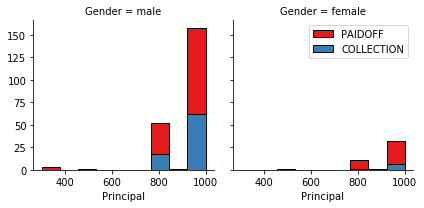

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

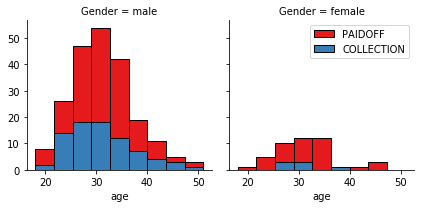

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

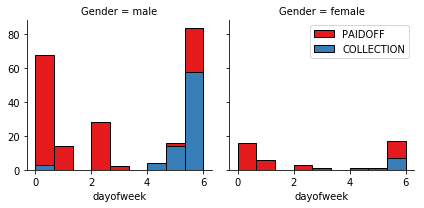

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head(20)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1
5,7,7,PAIDOFF,1000,30,2016-09-09,2016-10-08,36,college,male,4,1
6,8,8,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,male,4,1
7,9,9,PAIDOFF,800,15,2016-09-10,2016-09-24,26,college,male,5,1
8,10,10,PAIDOFF,300,7,2016-09-10,2016-09-16,29,college,male,5,1
9,11,11,PAIDOFF,1000,15,2016-09-10,2016-10-09,39,High School or Below,male,5,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1 and PAIDIFF to 0 and COLLECTION to 1


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

#df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)

df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

#Feature.head(10)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [21]:
#create train/test set
X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Knn Train set:',X_knn_train.shape, y_knn_train.shape)
print ('Knn Test set:',X_knn_test.shape, y_knn_test.shape)

Ks = 10
mean_acc = np.zeros((Ks-1))

ConfustionMx = [];
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_knn_train, y_knn_train)
    yhat_knn = neigh.predict(X_knn_test)
    mean_acc[n-1] = metrics.accuracy_score(y_knn_test, yhat_knn)

    
print('K Accuracy List:',mean_acc)


Knn Train set: (276, 8) (276,)
Knn Test set: (70, 8) (70,)
K Accuracy List: [0.67142857 0.65714286 0.71428571 0.68571429 0.75714286 0.71428571
 0.78571429 0.75714286 0.75714286]


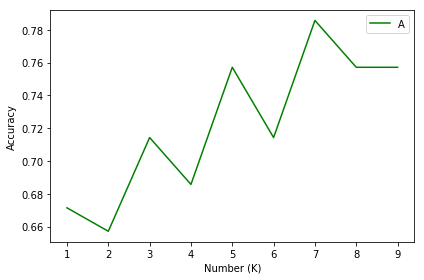

The best accuracy was 0.7857142857142857 with K= 7


In [22]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.legend('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number (K)')
plt.tight_layout()
plt.show()


print('The best accuracy was', mean_acc.max(),'with K=',mean_acc.argmax()+1)

Building final K Nearest Neighbor(KNN) model using full training set and K=7

In [23]:
knn_final_model = KNeighborsClassifier(n_neighbors = 7).fit(X, y)

# Decision Tree

In [24]:
#from sklearn import decision tree classifier
from sklearn.tree import DecisionTreeClassifier


In [25]:
#create train/test set
X_dt_train, X_dt_test, y_dt_train, y_dt_test = train_test_split(X, y, test_size=0.3, random_state=3)
print ('DT Train set:',X_dt_train.shape, y_dt_train.shape)
print ('DT Test set:',X_dt_test.shape, y_dt_test.shape)

dt = DecisionTreeClassifier(criterion='entropy', max_depth=4)
dt.fit(X_dt_train, y_dt_train)

yhat_dt=dt.predict(X_dt_test)

print('Accuracy Score for DT:',metrics.accuracy_score(y_dt_test, yhat_dt))
#print(y_dt_test)
#print(yhat_dt)

DT Train set: (242, 8) (242,)
DT Test set: (104, 8) (104,)
Accuracy Score for DT: 0.6538461538461539


Building final Decision Tree model using full training set 

In [26]:
dt_final_model = dt.fit(X,y)

# Support Vector Machine

In [27]:
from sklearn import svm
from sklearn.metrics import f1_score

clf_rbf = svm.SVC(kernel='rbf',gamma='auto')
clf_lin = svm.SVC(kernel='linear',gamma='auto')
clf_poly = svm.SVC(kernel='poly',gamma='auto')
clf_sig = svm.SVC(kernel='sigmoid',gamma='auto')

clf_lin

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
#create train/test set
X_svm_train, X_svm_test, y_svm_train, y_svm_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Knn Train set:',X_svm_train.shape, y_svm_train.shape)
print ('Knn Test set:',X_svm_test.shape, y_svm_test.shape)

#Train using rbf function
clf_rbf.fit(X_svm_train, y_svm_train)
yhat_rbf = clf_rbf.predict(X_svm_test)
print('RBF Yhat Result:',yhat_rbf)

#Train using linear function
clf_lin.fit(X_svm_train, y_svm_train)
yhat_lin = clf_lin.predict(X_svm_test)
print('Linear Yhat Result:',yhat_lin)

#Train using polynomial function
clf_poly.fit(X_svm_train, y_svm_train)
yhat_poly = clf_poly.predict(X_svm_test)
print('Polynomial Yhat Result:',yhat_poly)

#Train using sigmoid function
clf_sig.fit(X_svm_train, y_svm_train)
yhat_sig = clf_sig.predict(X_svm_test)
print('Sigmoid Yhat Result:',yhat_sig)


Knn Train set: (276, 8) (276,)
Knn Test set: (70, 8) (70,)
RBF Yhat Result: ['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF'
 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Linear Yhat Result: ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDO

The linear function returns the same value, so discarding that function from the evaluation.

In [29]:
#Evaluate using F1 score
print('RBF F1 Score :',f1_score(y_svm_test,yhat_rbf,average='weighted'))
print('Polynomial F1 Score :',f1_score(y_svm_test,yhat_poly,average='weighted'))
print('Sigmoid F1 Score :',f1_score(y_svm_test,yhat_sig,average='weighted'))


RBF F1 Score : 0.7275882012724117
Polynomial F1 Score : 0.7064793130366899
Sigmoid F1 Score : 0.6892857142857144


RBF function returns the best F1 Score, so that will be used in the final evaluation using the test data.

Building final Support Vector Machine(SVM) model using full training set and the RBF function.

In [30]:
svm_final_model = clf_rbf.fit(X,y)

# Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
#create train/test set



X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('LR Train set:',X_lr_train.shape, y_lr_train.shape)
print ('LR Test set:',X_lr_test.shape, y_lr_test.shape)

lr = LogisticRegression(C=0.01, solver='liblinear')
lr.fit(X_lr_train,y_lr_train)

yhat_lr = lr.predict(X_lr_test)
print('Accuracy Score for LR:',metrics.accuracy_score(y_lr_test, yhat_lr))

print('F1 for LR:',f1_score(y_lr_test, yhat_lr,average='weighted'))

#print(yhat_lr)
#print(y_lr_test)

LR Train set: (276, 8) (276,)
LR Test set: (70, 8) (70,)
Accuracy Score for LR: 0.6857142857142857
F1 for LR: 0.6670522459996144


Building final Logistic Regression model using full training set

In [33]:
lr_final_model = lr.fit(X,y)

# Model Evaluation using Test set

In [34]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [35]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-09-01 10:20:46--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-09-01 10:20:46 (450 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [36]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [37]:
#Prepare test data
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)

test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)

#Normalise the test data
test_X = test_Feature
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)
print(test_X.shape)

#Get dependant variable test data
test_y = test_df['loan_status'].values
#print(test_Feature)
#print(Feature)

(54, 8)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:15: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [38]:
#F1 Evaluation scores

#KNN F1 Evaluation
yhat_knn = knn_final_model.predict(test_X)
knn_f1 = f1_score(test_y, yhat_knn,average='weighted')
knn_jac = jaccard_similarity_score(test_y, yhat_knn)
#print(yhat_knn)
print('KNN F1 Score :',knn_f1)
print('KNN jaccard index Score :',knn_jac)

#Decision Tree F1 Evaluation
yhat_dt = dt_final_model.predict(test_X)
dt_f1 = f1_score(test_y, yhat_dt,average='weighted')
dt_jac = jaccard_similarity_score(test_y, yhat_dt)
#print(yhat_dt)
print('Decision Tree F1 Score :',dt_f1)
print('Decision Tree jaccard index Score :',dt_jac)

#Support Vector Machine F1 Evaluation
yhat_svm = svm_final_model.predict(test_X)
svm_f1 = f1_score(test_y, yhat_svm,average='weighted')
svm_jac = jaccard_similarity_score(test_y, yhat_svm)
#print(yhat_svm)
print('Support Vector Machine F1 Score :',svm_f1)
print('Support Vector Machine jaccard index Score :',svm_jac)

#Logistic Regression F1 Evaluation
yhat_lr = lr_final_model.predict(test_X)
lr_f1 = f1_score(test_y, yhat_lr,average='weighted')
lr_jac = jaccard_similarity_score(test_y, yhat_lr)

yhat_prob_lr = lr_final_model.predict_proba(test_X)
lr_logloss = log_loss(test_y, yhat_prob_lr)

print('Logistic Regression F1 Score :',lr_f1)
print('Logistic Regression jaccard index Score :',lr_jac)
print('Logistic Regression Log Loss Score :',lr_logloss)





KNN F1 Score : 0.7001989201477693
KNN jaccard index Score : 0.7222222222222222
Decision Tree F1 Score : 0.7283950617283951
Decision Tree jaccard index Score : 0.7777777777777778
Support Vector Machine F1 Score : 0.6212664277180406
Support Vector Machine jaccard index Score : 0.7222222222222222
Logistic Regression F1 Score : 0.6304176516942475
Logistic Regression jaccard index Score : 0.7407407407407407
Logistic Regression Log Loss Score : 0.5566084946309207


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.72    | 0.70     | NA      |
| Decision Tree      | 0.78    | 0.73     | NA      |
| SVM                | 0.72    | 0.62     | NA      |
| LogisticRegression | 0.74    | 0.63     | 0.56    |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>